In [ ]:
!pip install "tensorflow-text==2.8.*"


     |████████████████████████████████| 4.9 MB 5.2 MB/s 
     |████████████████████████████████| 462 kB 49.7 MB/s 


##  Importing the libraries

In [ ]:
from __future__ import absolute_import, division, print_function
# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import time
print(tf.__version__)#to check the tensorflow version

2.8.0


##  Shapechecker

Function to prevent loading of data of wrong shape

In [ ]:
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    if isinstance(names, str):
      names = (names,)

    shape = tf.shape(tensor)
    rank = tf.rank(tensor)

    if rank != len(names):
      raise ValueError(f'Rank mismatch:\n'
                       f'    found {rank}: {shape.numpy()}\n'
                       f'    expected {len(names)}: {names}\n')

    for i, name in enumerate(names):
      if isinstance(name, int):
        old_dim = name
      else:
        old_dim = self.shapes.get(name, None)
      new_dim = shape[i]

      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

##  Loading the datasets

In [ ]:
# Loading the datasets
english = pd.read_csv('/content/english.txt', sep='delimiter', engine = 'python', header=None)
kiuk = pd.read_csv('/content/Kikuyu.txt', sep='delimiter', engine = 'python', header=None)
kale = pd.read_csv('/content/kale.txt', sep='delimiter',  engine = 'python', header=None)
luo = pd.read_csv('/content/luo.txt', sep='delimiter', engine = 'python', header=None)

##  Previewing the datasets

In [ ]:
# print the shape of the various datasets
files = [english, kiuk, luo, kale]
dataset_names = ['English', 'Kikuyu', 'Luo', 'Kalenjin']
for file in files:
  #for index in range(len(dataset_names)):
    rows, columns = file.shape
    print(f'The dataset has {rows} rows and {columns} columns')
    

The dataset has 176 rows and 1 columns
The dataset has 176 rows and 1 columns
The dataset has 176 rows and 1 columns
The dataset has 176 rows and 1 columns


##  Pre_processing

In [ ]:
# (Unicode is the universal character encoding used to process, store and facilitate the interchange of text data in any language 
# while ASCII is used for the representation of text such as symbols, letters, digits, etc)

Preprocessing steps includes

- Converting the unicode file to ascii
- Creating a space between a word and the punctuation following it
eg: “he is a boy.” => “he is a boy .” Reference
- Replacing everything with space except (a-z, A-Z, “.”, “?”, “!”, “,”)
- Adding a start and an end token to the sentence so that the model know when to start and stop predicting.
- Removing the accents
- Cleaning the sentences
- Return word pairs in the format: [ENGLISH, LUO]
- Creating a word -> index mapping (e.g,. 'Further' -> 5) and vice-versa. (e.g., 5 -> 'Further' ) for each language.

In [ ]:
# Creating an index column for Kalenjin file
kale['index_col'] = kale.index

In [ ]:
# Creating an index column for Kalenjin file
english['index_col'] = kale.index

In [ ]:
# Joining the English and Kalenjin file with the Index column
df_kale = pd.merge(english, kale, on = 'index_col')

In [ ]:
# Renaming the Kalenjin Columns
df_kale.head()
df_kale.columns = ['feature', 'index', 'target']

In [ ]:
# Dropping the Index column in the Kalenjjin file
df_kale.columns
df_kale = df_kale.drop(columns = ['index'])

In [ ]:
# Displaying the first rows on the Kalenjin file
df_kale.head()

,feature,target
0,"Blessed are the undefiled in the way, who walk...","Boiboen che igesunotgei eng’ oret, Che bendote..."
1,"2 Blessed are they that keep his testimonies, ...","Boiboen ichek che ribei baornatosiekyik, Che c..."
2,3 They also do no iniquity: they walk in his w...,"Ee, mayaei ichek che ma bo iman; Bendote ortin..."
3,4 Thou hast commanded us to keep thy precepts ...,"Kiing’at konetisiosieguk, Ile kisub eng’ kagii..."
4,5 O that my ways were directed to keep thy sta...,"Ee, kata mie nda ka kimen ortinwekyuk Si kobii..."


In [ ]:
# Removing the numbers at the beginning of the feature column
df_kale['feature'] = df_kale['feature'].str.replace('\d+', '')

df_kale.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,feature,target
0,"Blessed are the undefiled in the way, who walk...","Boiboen che igesunotgei eng’ oret, Che bendote..."
1,"Blessed are they that keep his testimonies, a...","Boiboen ichek che ribei baornatosiekyik, Che c..."
2,They also do no iniquity: they walk in his ways.,"Ee, mayaei ichek che ma bo iman; Bendote ortin..."
3,Thou hast commanded us to keep thy precepts d...,"Kiing’at konetisiosieguk, Ile kisub eng’ kagii..."
4,O that my ways were directed to keep thy stat...,"Ee, kata mie nda ka kimen ortinwekyuk Si kobii..."


In [ ]:
df_kale['feature'] = df_kale['feature'].str.replace('\d+', '')

df_kale['target'] = df_kale['target'].str.replace('\d+', '')

df_kale

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,feature,target
0,"Blessed are the undefiled in the way, who walk...","Boiboen che igesunotgei eng’ oret, Che bendote..."
1,"Blessed are they that keep his testimonies, a...","Boiboen ichek che ribei baornatosiekyik, Che c..."
2,They also do no iniquity: they walk in his ways.,"Ee, mayaei ichek che ma bo iman; Bendote ortin..."
3,Thou hast commanded us to keep thy precepts d...,"Kiing’at konetisiosieguk, Ile kisub eng’ kagii..."
4,O that my ways were directed to keep thy stat...,"Ee, kata mie nda ka kimen ortinwekyuk Si kobii..."
...,...,...
171,My tongue shall speak of thy word: for all th...,Ingotien ng’elyeptanyu agobo ng’olyondeng’ung’...
172,Let thine hand help me; for I have chosen thy...,Ingochobok eung’ung’ kotoreta; Amu kialewen ko...
173,"I have longed for thy salvation, O Lord; and ...","Kigoama emosto agobo yetuneng’ung’, ee Jehovah..."
174,"Let my soul live, and it shall praise thee; a...","Ingosob sobondanyu, si kolosun; Ak ingotoreta ..."


In [ ]:
# from google.colab import files
# files.download("df_kale.csv")

In [ ]:
inp = df_kale['target'].to_list()

In [ ]:
targ = df_kale['feature'].to_list()

##  Creating tf_dataset

Creating a tf.data.Dataset of strings that shuffles and batches them efficiently:

In [ ]:
# Tells TensorFlow to create a buffer of at most buffer_size elements, and a background thread to fill that buffer in the background
BUFFER_SIZE = len(inp)

# Number of samples to be feed into the neural network
BATCH_SIZE = 3

# Creating the dataset and shuffling it 
dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset 

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
for example_input_batch, example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Iweech konyekyuk si mageer che ma nyolu. Ak isooba eng\xe2\x80\x99 ortinweguk.'
 b'Ikweng\xe2\x80\x99e kiboitiondeng\xe2\x80\x99ung\xe2\x80\x99 togeng\xe2\x80\x99ung\xe2\x80\x99; Ak ineta ng\xe2\x80\x99atutiguk.'
 b'Kaimenitu konyekyuk agobo ng\xe2\x80\x99olyondeng\xe2\x80\x99ung\xe2\x80\x99, Ye amwae ale, Igaigaa au?'], shape=(3,), dtype=string)

tf.Tensor(
[b' Turn away mine eyes from beholding vanity; and quicken thou me in thy way.'
 b' Make thy face to shine upon thy servant; and teach me thy statutes.'
 b' Mine eyes fail for thy word, saying, When wilt thou comfort me?'], shape=(3,), dtype=string)


##  Text processing

### i) Standardization

Since the model is dealing with multilingual text with a limited vocabulary standardization of the text is crucial. Steps;
1.  Unicode normalization to split accented characters
2.  replace compatibility characters with their ASCII equivalents.

In [ ]:
import tensorflow_text as tf_text

In [ ]:
# example of a text normalized and uni encoded
sample_text = tf.constant('Kiacheng’in eng’ muguleldanyu tugul')

print(sample_text.numpy())
print(tf_text.normalize_utf8(sample_text, 'NFKD').numpy())

b'Kiacheng\xe2\x80\x99in eng\xe2\x80\x99 muguleldanyu tugul'
b'Kiacheng\xe2\x80\x99in eng\xe2\x80\x99 muguleldanyu tugul'


In [ ]:
# Unicode normalization 
def tf_lower_and_split_punct(text):
  # Split accecented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [ ]:
# Priniting an example of the original text
print(sample_text.numpy().decode())

# printing the text afterunicode normalization
print(tf_lower_and_split_punct(sample_text).numpy().decode())

Kiacheng’in eng’ muguleldanyu tugul
[START] kiachengin eng muguleldanyu tugul [END]


In [ ]:
# Extracting and coverting input text to sequences of tokens
# max_vocab_size limit RAM usage during the initial scan of the training corpus to discover the vocabulary.
max_vocab_size = 25000 

input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

In [ ]:
# Reading one epoch of the training data with the adapt method 
input_text_processor.adapt(inp)

# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', ',', 'ak', 'eng', 'amu', 'ngatutiguk']

In [ ]:
# Using the Kalenjin TextVectorization layer to build the English layer with .adapt() method
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size)

output_text_processor.adapt(targ)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'thy', '[START]', '[END]', '.', 'i', ',', 'me', 'and']

In [ ]:
# Using the layers created to convert a batch of strings into a batch of token IDs
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[  2, 394,  59,  14, 254,  11, 133, 226,   4,   6],
       [  2, 414,  27, 197,   6,  30,   9,   4,   3,   0],
       [  2, 157,  59,  33,  12,   5,  37, 481,  36,   5]])>

Text(0.5, 1.0, 'Mask')

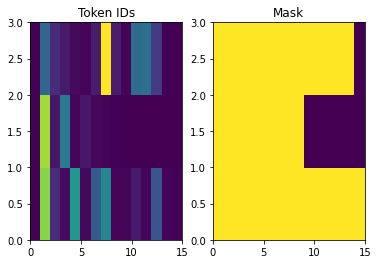

In [ ]:
# Applying the token IDs that are zero-padded that can be turned into a mask
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
# Defining constants for the model
# Embedding layer enables us to convert each word into a fixed length vector of defined size
embedding_dim = 512
units = 1024

##  The encoder

The first thing to do is build the encoder. The process is as follows:

1. Taking a list of token IDs. 

2. Using the embedding vector for each token.

3. Processessing the embeddings into a new sequence 

In [ ]:
# Applying the  list of token IDs
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    shape_checker = ShapeChecker()
    shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    shape_checker(output, ('batch', 's', 'enc_units'))
    shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [ ]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (3,)
Input batch tokens, shape (batch, s): (3, 15)
Encoder output, shape (batch, s, units): (3, 15, 1024)
Encoder state, shape (batch, units): (3, 1024)


##  The attention head

The decoder uses attention to selectively focus on parts of the input sequence. The attention takes a sequence of vectors as input for each example and returns an "attention" vector for each example. 

In [ ]:
# The BahdanauAttention class handles the weight matrices in a pair of dense layers and calls the builtin implementation
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    shape_checker = ShapeChecker()
    shape_checker(query, ('batch', 't', 'query_units'))
    shape_checker(value, ('batch', 's', 'value_units'))
    shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    shape_checker(context_vector, ('batch', 't', 'value_units'))
    shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

### i) Attention head layer

In [ ]:
# Creating a BahdanauAttention layer
attention_layer = BahdanauAttention(units)

In [ ]:
# Excluding the padding
(example_tokens != 0).shape

TensorShape([3, 15])

In [ ]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens

context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (3, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (3, 2, 15)


Text(0.5, 1.0, 'Mask')

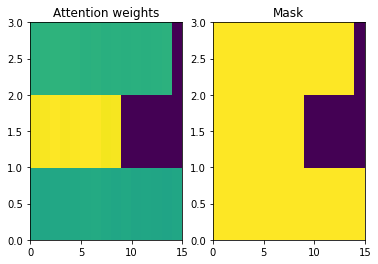

In [ ]:
# attention weights across the sequences at t=0
# t is used for slicing, for selecting different parts of the data.
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [ ]:
# Displaying the shape of the attention weights
attention_weights.shape

TensorShape([3, 2, 15])

In [ ]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

### ii) Toogle code

<Figure size 432x288 with 0 Axes>

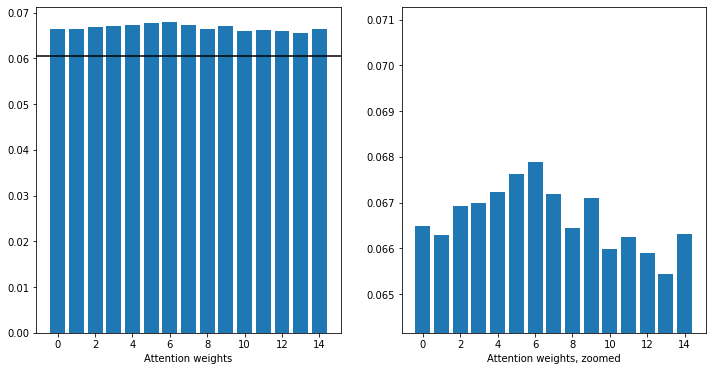

In [ ]:
# Plotting attention weights
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

### iii) The decoder

The decoder generates predictions for the next output token.
1. The decoder receives the complete encoder output.

2. It uses an RNN to keep track of what it has generated so far.

3. It uses its RNN output as the query to the attention over the encoder's output, producing the context vector.

4. It combines the RNN output and the context vector to generate the attention vector.

5. It generates logit predictions for the next token based on the attention vector.

In [ ]:
# Decoder class and its initializer creates all the necessary layers.

class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # The embedding layer convets token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    #  Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [ ]:
# Importing libraries
import typing
from typing import Any, Tuple

In [ ]:
# Applying the call method for this layer which  takes and returns multiple tensors.
# Organizing those into simple container classes.
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [ ]:
# Implementing the call method
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  shape_checker = ShapeChecker()
  shape_checker(inputs.new_tokens, ('batch', 't'))
  shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  shape_checker(inputs.mask, ('batch', 's'))

  if state is not None:
    shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  shape_checker(context_vector, ('batch', 't', 'dec_units'))
  shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [ ]:
Decoder.call = call

In [ ]:
# Implementing  of the decoder 
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [ ]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [ ]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (3, 1, 486)
state shape: (batch_size, dec_units) (3, 1024)


In [ ]:
# Sampling a token with the logits
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [ ]:
# Decoding the token as the first word of the output
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['speak'],
       ['continually'],
       ['voice']], dtype='<U14')

In [ ]:
# Applying the same enc_output, mask and sampled tokens as new tokens.

dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [ ]:
# Generating a second set of logits using the decoder
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['man'],
       ['rivers'],
       ['hath']], dtype='<U14')

##  Training

To train the model we'll follow the following steps:

1. A loss function and optimizer to perform the optimization.

2. A training step function defining how to update the model for each input/target batch.

3. A training loop to drive the training and save checkpoints.

### i) Define the loss function

In [ ]:
# Implementing the loss function and optimizer to perform the optimization.
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    shape_checker = ShapeChecker()
    shape_checker(y_true, ('batch', 't'))
    shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

### ii) Implementing the training step

In [ ]:
# Implementing a model class, the training process will be implemented as the train_step method 
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor, 
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    self.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [ ]:
# Getting a batch of input_text, target_text from the tf.data.Dataset.
def _preprocess(self, input_text, target_text):
  self.shape_checker(input_text, ('batch',))
  self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  self.shape_checker(input_tokens, ('batch', 's'))
  self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [ ]:
TrainTranslator._preprocess = _preprocess

In [ ]:
# Applying the _train_step method
def _train_step(self, inputs):
  input_text, target_text = inputs  

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables 
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [ ]:
TrainTranslator._train_step = _train_step

In [ ]:
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [ ]:
TrainTranslator._loop_step = _loop_step

### iii) Test the training step

In [ ]:
# Building a TrainTranslator and configuring it for training using the Model.compile method
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
# Testing the train_step model
np.log(output_text_processor.vocabulary_size())

6.186208623900494

In [ ]:
# Applying the tf.function-wrapped _tf_train_step, to maximize performance while training
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [ ]:
TrainTranslator._tf_train_step = _tf_train_step

In [ ]:
translator.use_tf_function = True

In [ ]:
# Tracing the function
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.8170986>}

In [ ]:
# Printing out the Batch loss of our model
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.675062>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.4519854>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.9306383>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.5844378>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.8389463>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.099932>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.2971683>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=3.0378928>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.9476435>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=2.7302275>}

CPU times: user 32.7 s, sys: 846 ms, total: 33.6 s
Wall time: 38.3 s


In [ ]:
# Plotting our batch losses
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

................

In [ ]:
# Building another model to train
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

### iv) Train the model

In [ ]:
# Training a couple of epochs by applying the callbacks.Callback method
# to collect the history of batch losses
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
# Displaying the batch loss using 15 epochs 
train_translator.fit(dataset, epochs=15,
                     callbacks=[batch_loss])

In [ ]:
# Plotting the epochs
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

##  Translate

In [ ]:
# Executing the full text => texttranslation
# This is by inverting the text => token IDsmapping provided by the output_text_processor
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

### i) Convert IDs to text

In [ ]:
# Implementing the tokens_to_text which converts from token IDs to human readable text.
def tokens_to_text(self, result_tokens):
  shape_checker = ShapeChecker()
  shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
# Inputting some random token IDs and see what it generates (example)
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

### ii) Sample from the decoder's predictions

In [ ]:
# Taking the decoder's logit outputs and samples token IDs from the distribution
def sample(self, logits, temperature):
  shape_checker = ShapeChecker()
  # 't' is usually 1 here.
  shape_checker(logits, ('batch', 't', 'vocab'))
  shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else: 
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Translator.sample = sample

In [ ]:
# Random inputs (example)
example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

### iii) Implement translation loop

In [ ]:
# Taking the results into python lists before joining them  using tf.concat into tensors.
# This unfolds the graph out to max_length iterations.
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
# Running a simple input to view the translation
%%time
input_text = tf.constant([
    'Boiboen che igesunotgei eng’ oret.', # "Blessed are the undefiled in the way."
    'Kilosu Jehovah', # "I have gone astray like a lost sheep"
])


result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

##  Visualize the process

In [ ]:
# Calculating the sum of the attention over the input which should return all ones.
a = result['attention'][0]

print(np.sum(a, axis=-1))

In [ ]:
# The attention distribution for the first output step of the first example
# It is focused than it was in the untrained model
_ = plt.bar(range(len(a[0, :])), a[0, :])

In [ ]:
# There is some rough alignment between the input and output words
plt.imshow(np.array(a), vmin=0.0)

### i) Labelled attention plots

In [ ]:
# Visualizing the attention plots.
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_lower_and_split_punct(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

## Export

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

##  Conclusion

a). Did we have the right data?


b). Do we need other data to answer our question?

c) Did we have the right question?

## Installations

In [ ]:
!pip install ipykernel>=5.1.2
!pip install pydeck
!pip install streamlit==0.75.0
!pip install pyngrok
!pip install streamlit -q
!pip install streamlit --upgrade
!pip install streamlit-option-menu


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 7.9 MB/s 
     |████████████████████████████████| 133 kB 52.6 MB/s 
     |████████████████████████████████| 793 kB 57.5 MB/s 
     |████████████████████████████████| 132 kB 54.5 MB/s 
     |████████████████████████████████| 428 kB 51.3 MB/s 
     |████████████████████████████████| 381 kB 29.2 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Attempting uninstall: ipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.5 MB 6.1 MB/s 
     |████████████████████████████████| 181 kB 40.4 MB/s 
     |████████████████████████████████| 78 kB 7.9 MB/s 
     |████████████████████████████████| 111 kB 40.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=365cfa04d3e93ccbff470ddb560c5d689783342517b8f72797c149e2d5682291
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19582 sha256=3032f8ad88f84544b75a0c42f4a23b7266b7e2028a495551a629ad8eaff61109
  Stored in directory: /root/.cache/pip/wheels/5f/55/ab/36a76989f7f88d9ca7b1f68da6d94252bb6a8d6ad4f18e04e9
Successfully built blinker validators
Looking in indexes: https://pypi.org/simple, https://us

## App

In [ ]:
%%writefile finalLHTranslation.py

import streamlit as st
import pandas as pd
import plotly.figure_factory as ff
from streamlit_option_menu import option_menu
from textblob import TextBlob 
import tensorflow as tf
 
 

# let's do the navigation bar first

selected = option_menu(
      menu_title= None, options=['Home','Features', 'About'], icons =['house','book','boxes'],menu_icon='cast', default_index=0, orientation = 'horizontal'
  )



# setting containers
header = st.container()
translation = st.container()
dataset = st.container()
features = st.container()
modelTraining = st.container()

# setting columns within the header container
with header:
  col1, col2 = st.columns([1,6])

  with col1:
    st.image(
    "https://cdn0.iconfinder.com/data/icons/joker-circus-by-joker2011-d3g8h6s/256/lion.png", width=100,)

  with col2:
    st.markdown("<h1 style='text-align: left; color: Orange;'> Lion Heart Translation</h1>", unsafe_allow_html=True)



  # st.image(
  #   "https://cdn0.iconfinder.com/data/icons/joker-circus-by-joker2011-d3g8h6s/256/lion.png", width=100,)
  # st.markdown("<h1 style='text-align: center; color: Purple;'> Lion Heart Translation</h1>", unsafe_allow_html=True)
  # st.text("Lion Heart Translation is an App who's main porpose is to translate Kenyan local languages, that is Kalenjin, Luo and Kikuyu to English and vise versa. It's Using a tensorflow neural network model in order to do this.")
with st.expander("Pick out a theme of your liking?"):
  THEMES = [
    "light",
    "dark",
    "green",
    "blue",]
  GITHUB_OWNER = "streamlit"



# modeling ie translation code
if selected == 'Home':
  with translation:
    from textblob import TextBlob 
    import spacy
    from gensim.summarization import summarize
    sp = spacy.load('en_core_web_sm')
    from spacy import displacy
 
    # Add selectbox in streamlit
    st.markdown("""<span style="word-wrap:break-word;">Lion Heart Translation is an App who's main porpose is to translate Kenyan local languages, that is Kalenjin, Luo and Kikuyu to English and vise versa. It's Using a tensorflow neural network model in order to do this.</span>""", unsafe_allow_html=True)
    option = st.selectbox(
     'Which Local language would you like to translate to?',
        ('none', 'Kikuyu', 'Kalenjin', 'Luo'))
    st.write('You selected:', option)

    def main():
      text = st.text_area("Enter Text to translate here: ","lorem ipsum...",key = "<255>")
      if st.button("Translate"):
        input_text = tf.constant(text)
        result = translator.translate(input_text = input_text)
        show = result['text'][0].numpy().decode()
        st.success(show)

if __name__=='__main__':
  main()


if selected == 'About':
  with dataset:
    st.header('About')
    st.markdown("""<span style="word-wrap:break-word;">The data used to build this model was obtained from a chapter in the Bible in each of the four languages.</span>""", unsafe_allow_html=True)
    
    # st.text('The data used to build this model was obtained from a chapter in the Bible in each of the four languages.')
    st.text("here's what the Kalenjin looks side by side with it's English translation")
    kaleme = pd.read_csv('/content/kaleme.csv', sep='delimiter', engine = 'python', header=None)
    st.write(kaleme.head(5))

if selected == 'Features':
  with features:
    st.header('Features')
    st.markdown('* **Hyperparameter tuning:** Here the user can tweak the model settings in pursuit of higher accuracy')
    st.markdown('* **Language Dropdown:** Here the user can tweak the model settings in pursuit of higher accuracy')
    st.markdown('* **Translation textbox:** Here the user can tweak the model settings in pursuit of higher accuracy')

Writing finalLHTranslation.py


In [ ]:
! streamlit run finalLHTranslation.py & npx localtunnel --port 8501


2022-06-15 18:57:50.949 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.125.108.25:8501

npx: installed 22 in 6.364s
your url is: https://ninety-regions-relate-34-125-108-25.loca.lt
2022-06-15 18:59:24.277 'pattern' package not found; tag filters are not available for English
